In [54]:
import pandas as pd
import sqlalchemy
import math
import os, sys, copy, random, pickle, cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append("../")

%load_ext autoreload
%autoreload 2

from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState

from modules.AnalysisHelpers import ( 
         exploreImgs, buildImgComparisonData, subprocEval)

from modules.EvalHelpers import EvalTracker, EvalDataset
from modules.ControlEval import EvalFactory
from modules.DataSchemas import ScoreSchema
from modules.EvalHelpers import OutcomeData, DFHelper

from modules.EvalHelpers import AggEval, DFHelper

from modules.EvalSuite import EvalSuite

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Build OutcomeData from eval to work with

In [319]:
#different trackers here
b_log, b_eval_log = False, False
vidfn = 'data/proc/tmp/dec14/output5.proc1.proc1.avi'
outcome0 = subprocEval(f_pathfn = vidfn, algo_enum=0, b_log=b_log, b_eval_log=b_eval_log)
outcome1 = subprocEval(f_pathfn = vidfn, algo_enum=1, b_log=b_log, b_eval_log=b_eval_log)
outcome2 = subprocEval(f_pathfn = vidfn, algo_enum=2, b_log=b_log, b_eval_log=b_eval_log)

In [2]:
b_log, b_eval_log = True, True
vidfn = 'data/proc/tmp/dec14/output6.proc1.avi'

algo_enums = [str(x) for x in range(3)]

d_outcome = {}
for _enum in algo_enums:
    
    _outcome = subprocEval(f_pathfn = vidfn, algo_enum=_enum, 
                           b_log=b_log, b_eval_log=b_eval_log)
    
    d_outcome[_enum] = _outcome.copy()


START - running eval module...
[                            ]
------------------------------
output db: data/usr/eval_tmp.db
output tbl: outcome_dataframe
eval time: 10.65
outcome rows: 383 cols: 48 

num frames:                  383 
obj enums scored/tracked:    0,1 / 0 
num scored frames:           10 | 0,22,40...125,188,380 
-------
agg_calcBaselineBallUnitsAway   -0.18
agg_checkBothContainsOther       1.00
agg_checkTrackSuccess            0.86
fagg_less_than_20_pix_balls_away   -0.28
fagg_less_than_30_pix_success       1.00
-----
subproc time: 12.76

START - running eval module...
[                            ]
------------------------------
output db: data/usr/eval_tmp.db
output tbl: outcome_dataframe
eval time: 9.802
outcome rows: 383 cols: 48 

num frames:                  383 
obj enums scored/tracked:    0,1 / 0 
num scored frames:           10 | 0,22,40...125,188,380 
-------
agg_calcBaselineBallUnitsAway   -0.18
agg_checkBothContainsOther       1.00
agg_checkTrackSuccess   

### Show Reports from CmpAlgoReport

In [166]:
from modules.EvalSuite import EvalSuite, CmpAlgoReport

In [167]:
cmpB = CmpAlgoReport(
    benchmark_outcome_data=d_outcome['0'],
    current_outcome_data=d_outcome['2']
             )

,improvements,deprovements,sames
checkTrackSuccess,24.000,0.000,359.000


,improvements,deprovements,sames
calcBaselineBallUnitsAway,1,1,8
checkBothContainsOther,0,0,10
checkTrackSuccess,0,0,10
distanceFromBaseline,1,1,8


,diff,current,benchmark
,mean,mean,mean
agg_checkTrackSuccess,0.063,0.924,0.862
agg_calcBaselineBallUnitsAway,-0.004,-0.184,-0.180
agg_checkBothContainsOther,0.000,1.000,1.000
agg_distanceFromBaseline,-0.043,-9.015,-8.972


diff         current          benchmark  \
                                    mean       n    mean        n      mean   
fagg_less_than_20_pix_balls_away  -0.019   0.000  -0.301    2.000    -0.282   
fagg_less_than_30_pix_success      0.000  24.000   1.000  321.000     1.000   

                                           
                                        n  
fagg_less_than_20_pix_balls_away    2.000  
fagg_less_than_30_pix_success     297.000

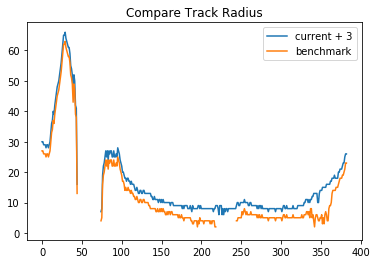

In [168]:
cmpB.report1()

From the above we can see that although algo_enum=2 improves from algo_enum=0 on trackSuccess, it's slightly less accurate on distanceFromBaseline

### Built Tests

### Build LargestDiscrepancy Report

In [233]:
from modules.EvalSuite import CmpAlgoReport

In [240]:
ret = cmpB.largestDiscrepancy(checkTrackSuccess=1, max_n=5)
display(ret)
foi_list = [int(x) for x in ret.index]
print foi_list

,diff,current,benchmark
,checkTrackSuccess,checkTrackSuccess,checkTrackSuccess
239,1.000,1.000,0.000
232,1.000,1.000,0.000
223,1.000,1.000,0.000
224,1.000,1.000,0.000
225,1.000,1.000,0.000


[239, 232, 223, 224, 225]


In [234]:
cmpB.largestDiscrepancy(calcBaselineBallUnitsAway=0, max_n=5)

,diff,current,benchmark
,calcBaselineBallUnitsAway,calcBaselineBallUnitsAway,calcBaselineBallUnitsAway
188,-0.038,-0.357,-0.319
380,0.004,-0.192,-0.196
0,0.000,-0.079,-0.079
22,0.000,-0.031,-0.031
40,0.000,-0.168,-0.168


In [231]:
cmpB.largestDiscrepancy(distanceFromBaseline=0, max_n=10)

,diff,current,benchmark
,distanceFromBaseline,distanceFromBaseline,distanceFromBaseline
188,-0.527864,-5.000000,-4.472136
380,0.183954,-8.062258,-8.246211
0,0.000000,-5.385165,-5.385165
22,0.000000,-2.828427,-2.828427
40,0.000000,-15.811388,-15.811388
78,0.000000,-19.646883,-19.646883
84,0.000000,-10.000000,-10.000000
125,0.000000,-5.385165,-5.385165
1,NaN,NaN,NaN


### ScratchPad

In [30]:
# here we see how to index columns using top-level of MultiIndex
# by chosing to make it a list or a scalar affects what's returned
display(df[['diff']][:1])
display(df['diff'][:1])

print df[['diff']].columns   #returns multi-index
print '----'
print df['diff'].columns    # returns single-index

try:df['calcBaselineBallUnitsAway']
except:print 'failed1'
try:df[['calcBaselineBallUnitsAway']]
except: print 'failed2'

diff                                                  \
  calcBaselineBallUnitsAway checkBaselineInsideTrack checkBothContainsOther   
0                       0.0                      0.0                    0.0   

                                                     \
  checkEitherContainsOther checkTrackInsideBaseline   
0                      0.0                      0.0   

                                                               \
  checkTrackInsideBaselineRect checkTrackSuccess compareRadii   
0                          0.0               0.0          0.0   

                                                           
  distanceFromBaseline propBaselineRadius propTrackRadius  
0                  0.0                0.0             0.0

,calcBaselineBallUnitsAway,checkBaselineInsideTrack,checkBothContainsOther,checkEitherContainsOther,checkTrackInsideBaseline,checkTrackInsideBaselineRect,checkTrackSuccess,compareRadii,distanceFromBaseline,propBaselineRadius,propTrackRadius
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


MultiIndex(levels=[[u'current', u'diff', u'benchmark'], [u'calcBaselineBallUnitsAway', u'checkBaselineInsideTrack', u'checkBothContainsOther', u'checkEitherContainsOther', u'checkTrackInsideBaseline', u'checkTrackInsideBaselineRect', u'checkTrackSuccess', u'compareRadii', u'distanceFromBaseline', u'propBaselineRadius', u'propTrackRadius']],
           labels=[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
----
Index([u'calcBaselineBallUnitsAway', u'checkBaselineInsideTrack',
       u'checkBothContainsOther', u'checkEitherContainsOther',
       u'checkTrackInsideBaseline', u'checkTrackInsideBaselineRect',
       u'checkTrackSuccess', u'compareRadii', u'distanceFromBaseline',
       u'propBaselineRadius', u'propTrackRadius'],
      dtype='object')
failed1
failed2


In [157]:
# example of sorting by column
my_df.sort_values(by=['improvements'], ascending=False)

,deprovements,sames,improvements
propTrackRadius,0,267,116
checkTrackSuccess,0,359,24
calcBaselineBallUnitsAway,1,381,1
compareRadii,0,382,1
distanceFromBaseline,1,381,1
checkBaselineInsideTrack,0,383,0
checkBothContainsOther,0,383,0
checkEitherContainsOther,0,383,0
checkTrackInsideBaseline,0,383,0
checkTrackInsideBaselineRect,0,383,0


In [132]:
from modules.EvalHelpers import OutcomeData

In [137]:
od = OutcomeData(outcomeDf=d_outcome['0'])

In [143]:
diff_pd(od.outcomeData, d_outcome['0'])

they are the same according to diff_pd


In [142]:
def diff_pd(df1, df2):
    '''
    Identify differences between two pandas DataFrames
    https://stackoverflow.com/questions/17095101/outputting-difference-in-two-pandas-dataframes-side-by-side-highlighting-the-d
    '''
    assert (df1.columns == df2.columns).all(), \
        "DataFrame column names are different"
    if any(df1.dtypes != df2.dtypes):
        "Data Types are different, trying to convert"
        df2 = df2.astype(df1.dtypes)
    if df1.equals(df2):
        print 'they are the same according to diff_pd'
        return None
    else:
        # need to account for np.nan != np.nan returning True
        diff_mask = (df1 != df2) & ~(df1.isnull() & df2.isnull())
        ne_stacked = diff_mask.stack()
        changed = ne_stacked[ne_stacked]
        changed.index.names = ['id', 'col']
        difference_locations = np.where(diff_mask)
        changed_from = df1.values[difference_locations]
        changed_to = df2.values[difference_locations]
        return pd.DataFrame({'from': changed_from, 'to': changed_to},
                            index=changed.index)


In [ ]:
od.displaySeriesPlot()

### Pandas ScratchPad

##### Explore the mini-df

In [56]:
mini = cmpB.benchmark.aggFilterDfh.df
mini

,mean,n
fagg_less_than_20_pix_balls_away,0.282109,2.0
fagg_less_than_30_pix_success,1.000000,297.0


In [74]:
mini_stack = mini.stack()
mini_stack

fagg_less_than_20_pix_balls_away  mean      0.533238
                                  n        16.000000
fagg_less_than_30_pix_success     mean      1.000000
                                  n       310.000000
dtype: float64

In [75]:
mini.index

Index([u'fagg_less_than_20_pix_balls_away', u'fagg_less_than_30_pix_success'], dtype='object')

In [76]:
mini_stack.index

MultiIndex(levels=[[u'fagg_less_than_20_pix_balls_away', u'fagg_less_than_30_pix_success'], [u'mean', u'n']],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])

In [77]:
mini_stack.T

fagg_less_than_20_pix_balls_away  mean      0.533238
                                  n        16.000000
fagg_less_than_30_pix_success     mean      1.000000
                                  n       310.000000
dtype: float64

##### Easiest Way to combine two dataframes and note them as distinct

In [79]:
#on axis=1, dif-df's are ordered by col, so columns are MutliIndex
axis = 1

d_tmp = {'current':mini, 'benchmark':mini}

df_concat = pd.concat(d_tmp.values(), keys=d_tmp.keys(), axis=axis)

print 'cols:  %s', str(df_concat.columns)
print 'index: %s', str(df_concat.index)

df_concat

cols:  %s MultiIndex(levels=[[u'current', u'benchmark'], [u'mean', u'n']],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])
index: %s Index([u'fagg_less_than_20_pix_balls_away', u'fagg_less_than_30_pix_success'], dtype='object')


current        benchmark       
                                      mean      n      mean      n
fagg_less_than_20_pix_balls_away  0.533238   16.0  0.533238   16.0
fagg_less_than_30_pix_success     1.000000  310.0  1.000000  310.0

In [80]:
# on axis=0, df's are ordered by row, so rows are MultiIndex
axis = 0

d_tmp = {'current':mini, 'benchmark':mini}

df_concat = pd.concat(d_tmp.values(), keys=d_tmp.keys(), axis=axis)

print 'cols:  %s', str(df_concat.columns)
print 'index: %s', str(df_concat.index)

df_concat

cols:  %s Index([u'mean', u'n'], dtype='object')
index: %s MultiIndex(levels=[[u'current', u'benchmark'], [u'fagg_less_than_20_pix_balls_away', u'fagg_less_than_30_pix_success']],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])


mean      n
current   fagg_less_than_20_pix_balls_away  0.533238   16.0
          fagg_less_than_30_pix_success     1.000000  310.0
benchmark fagg_less_than_20_pix_balls_away  0.533238   16.0
          fagg_less_than_30_pix_success     1.000000  310.0

##### here's an attempt to combine dataframes with manually created MultiIndex

In [ ]:
iters = [list(mini.index), ['first']]
multi_ind_1 = pd.MultiIndex.from_product(iters, names=('criteria','dfnum'))
mini1 = pd.DataFrame(mini, index=multi_ind_1)
mini1

In [69]:
iters = [list(mini.index), ['second']]
multi_ind_2 = pd.MultiIndex.from_product(iters, names=('criteria','dfnum'))
mini2 = pd.DataFrame(data=mini.values, index=multi_ind_2, columns=mini.columns)

mini2

,,mean,n
criteria,dfnum,,
fagg_less_than_20_pix_balls_away,second,0.533238,16.0
fagg_less_than_30_pix_success,second,1.000000,310.0


In [ ]:
iters = [list(mini.index), ['first','second']]
multi_ind = pd.MultiIndex.from_product(iters, names=('criteria','dfnum'))
multi_ind